In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.3'
           
import matplotlib.pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample
from sklearn.linear_model import Ridge


import jax
from jax import random, numpy as jnp
from flax.core import freeze, unfreeze


import sys
sys.path.append('../../pdeX')
from DeepModx import pdeX

from time import time

%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pickle

In [3]:
sns.set(font_scale=1.5)
sns.set_style("white")


# Loading data

In [4]:
nn_shared_features = []
nn_specific_features = [65,65,65,65,1]


noise_level = 0.5


x     = np.load('../../data/KS_x.npy')
t     = np.load('../../data/KS_t.npy')

u0     = np.array(np.load('../../data/KS_u.npy'),dtype=np.float32)
u     = u0 + noise_level*np.std(u0)*np.random.randn(u0.shape[0],u0.shape[1])

nx = 200
nt = 200

number_of_samples=2000


#X_train = np.load('X_train.npy')

In [5]:
a_file = open("new_params.pkl", "rb")
new_params = pickle.load(a_file)

#a_file = open("state.pkl", "rb")
#new_state = pickle.load(a_file)

scale_from_outputs = np.load('scale_from_outputs.npy')

## auxiliary function

In [6]:

def X_new(nx,nt):
    tmax = t.max()
    xmax = x.max()
    x1 = jnp.linspace(x.min(), x.max(), nx)
    t1 = jnp.linspace(t.min(), t.max(), nt)    
    t_grid, x_grid = jnp.meshgrid(t1, x1, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/tmax).reshape(-1, 1), (x_grid/xmax).reshape(-1, 1)], axis=1)

    return Xnn

# rebuilding NN

In [7]:
model = pdeX(nn_shared_features, nn_specific_features, 1)
variables = model.init(random.PRNGKey(42), X_new(nx,nt))

In [8]:
state, params = variables.pop('params')

In [9]:
new_variables = freeze({'params': new_params, **state})

In [10]:
uu1 = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))
uu = uu1[0][0].reshape(nt,nx)

In [11]:
uu1[0][0].shape

(40000, 1)

In [12]:
theta = uu1[0][2][0]

# Plots

In [13]:
idx = resample(np.arange((u.ravel()).shape[0]),replace=False,random_state=0,n_samples=number_of_samples)
# recasting for plots    
u_sbv = np.zeros(u.shape).ravel()
u_sbv[idx] = np.ones(u.shape).ravel() [idx]
u_sb = u_sbv.reshape(u.shape)
u_sb = np.array(u_sb,dtype=np.int32)

In [14]:
u_sb

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [15]:
u_sbv.shape

(257024,)

In [16]:
x_grid,  t_grid = np.meshgrid(x,  t, indexing="ij")
idx_g1 = np.logical_and(t_grid>45,t_grid<50)
idx_g2 = np.logical_and(idx_g1,x_grid>49)
idx_g3 = np.logical_and(idx_g2,u_sb>0)
mask0 = np.zeros_like(idx_g2)
mask0[idx_g2] = 1

In [17]:
# recasting for plots    
u_sbv = np.zeros(u.shape).ravel()
u_sbv[idx] = np.ones(u.shape).ravel() [idx]
u_sb = u_sbv.reshape(u.shape)
u_sb = np.array(u_sb,dtype=np.int32)


mask = np.zeros_like(idx_g3)
mask[idx_g3] = 1

In [18]:
np.where(mask0>0)

(array([ 499,  499,  499, ..., 1023, 1023, 1023]),
 array([113, 114, 115, ..., 122, 123, 124]))

In [19]:
xini = np.where(mask0>0)[0][0]
xfin = np.where(mask0>0)[0][-1]
tini = np.where(mask0>0)[1][0]
tfin = np.where(mask0>0)[1][-1]
print(xini,xfin)
print(tini,tfin)


499 1023
113 124


In [20]:
print(x[xini],x[xfin])
print(t[tini],t[tfin])

49.087385212340514 100.53096491487338
45.2 49.6


In [21]:
nxx = np.arange(xini,xfin).shape[0]+1

In [22]:
ntt = np.arange(tini,tfin).shape[0]+1

In [23]:
idx = resample(np.arange(u[mask0].shape[0]),replace=False,random_state=0,n_samples=number_of_samples)

In [24]:
mask = np.zeros_like(u[mask0])
mask[idx] = 1
mask = mask.reshape(nxx,ntt)
mask = np.array(mask,dtype=np.int32)

In [25]:

def X_new(nx,nt):
    tmax = t.max()
    xmax = x.max()
    x1 = jnp.linspace(x[xini], x[xfin], nx)
    t1 = jnp.linspace(t[tini], t[tfin], nt)    
    t_grid, x_grid = jnp.meshgrid(t1, x1, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/tmax).reshape(-1, 1), (x_grid/xmax).reshape(-1, 1)], axis=1)

    return Xnn

In [26]:
uu1 = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))
uu = uu1[0][0].reshape(nt,nx)

[]

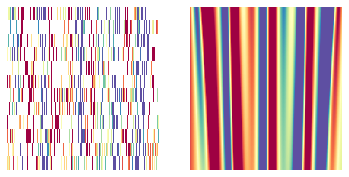

In [27]:
fig,ax = plt.subplots(1,2, figsize=(6,3))

bx = sns.heatmap(((u[mask0].reshape(nxx,ntt)*mask).T),ax=ax[0],mask = (np.ones_like(mask)-mask).T,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

bx = sns.heatmap(uu*scale_from_outputs,ax=ax[1],vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

[]

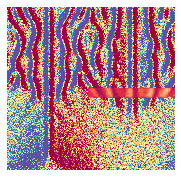

In [28]:
fig,ax = plt.subplots(1,1, figsize=(3,3))

bx = sns.heatmap(u.T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
ax.contour((u*mask0).T)

bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])




In [29]:
np.save('data_input',((u[mask0].reshape(nxx,ntt)*mask).T))
np.save('recovered',uu*scale_from_outputs)

np.save('mask',(np.ones_like(mask)-mask).T)


np.save('data_input_overall',u.T)
np.save('data_input_overallC',(u*mask0).T)
